## Imports

In [74]:
from IPython import get_ipython
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [75]:
import zipfile
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import Image, display

import plotly.express as px
from src.config import PATH, DATA_DIR
from src.data.process_data import (reduce_memory_usage, load_customer_dataset, 
                                   load_product_dataset, load_purchase_dataset, 
                                   load_views_dataset, load_labels_dataset)

pd.options.plotting.backend = "plotly"
ZIP_PATH = DATA_DIR / 'purchaseprediction_fulldata.zip'

In [76]:
# # unzip folder into data/raw
# with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
#     zip_ref.extractall(DATA_DIR / 'raw')

Github will not render interactive plots, so for upload convert all plots to image which are visible on github.

In [303]:
plots_as_images = True

def show_fig(fig, plots_as_images=plots_as_images):
    """Either print the plot as a static image or an interactive object"""
    if plots_as_images:
        display(Image(fig.to_image()))
    else:
        fig.show()

## Customers

- memory usage reduced from 29.7Mb to 3.8Mb
- 40282 customers have NaN country - imputed to 'Unknown'
- 77% of customers identify as Female
- only 150 of the 398,841 customers are Premier - can probably exclude this feature
- 1.5% of customers have very unlikely birth years, before 1910 or after 2010.
- No made up countries
- 31% of customers are from the UK, the most of any country.

In [461]:
customers_df = load_customer_dataset()
customers_df.sample(5).style.set_caption("""Sample of customers dataset""")

,customerId,isFemale,country,yearOfBirth,isPremier
202257,308041,True,UK,1982,False
145032,122313,False,UK,2001,False
334122,132063,True,UK,1988,False
244469,239190,False,Germany,1987,False
225696,329531,True,UK,1989,False


In [466]:
(customers_df
 .eval("""isMillenial = 1980 <= yearOfBirth <= 1999""")
 .agg(isMillenialPCT=('isMillenial','mean'))
 .style.set_caption("""Percentage of Millenial customers""")
)

,isMillenial
isMillenialPCT,0.779569


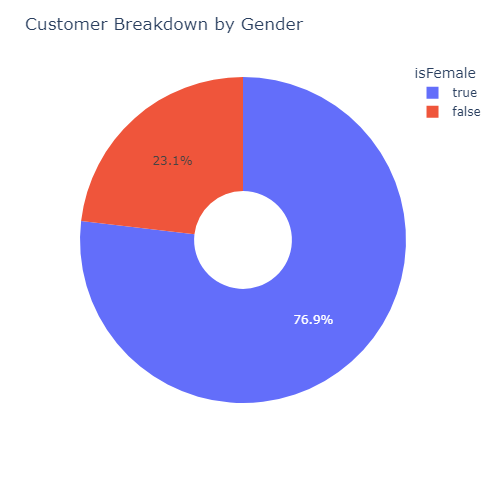

In [73]:
tmp = \
(customers_df
 .groupby(['isFemale'], as_index=False)
 .agg(count=('customerId','count')))

fig = \
(px.pie(tmp, values='count', names='isFemale', hole=0.3)
 .update_layout(width=500, height=500,
                title='Customer Breakdown by Gender',
                legend_title_text='isFemale'))

show_fig(fig)

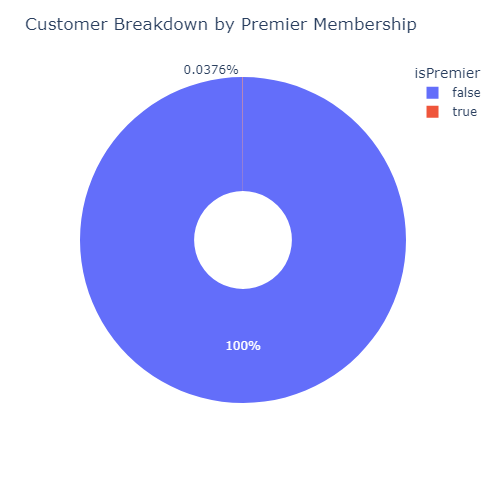

In [7]:
tmp = \
(customers_df
 .groupby(['isPremier'], as_index=False)
 .agg(count=('customerId','count')))

fig = \
(px.pie(tmp, values='count', names='isPremier', hole=0.3)
 .update_layout(width=500, height=500,
                title='Customer Breakdown by Premier Membership',
                legend_title_text='isPremier'))

show_fig(fig)

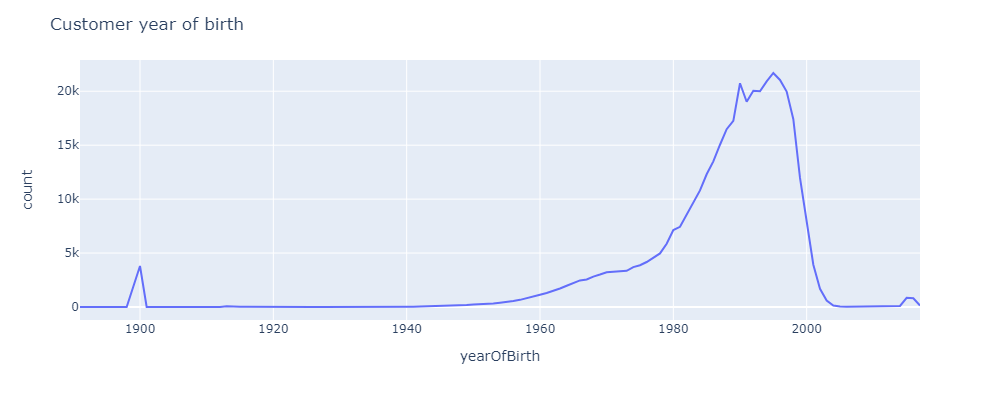

In [8]:
fig = \
(customers_df
 .groupby(['yearOfBirth'], as_index=False)
 .agg(count=('customerId','count'))
 .plot(x='yearOfBirth', y='count')
 .update_layout(width=1000, height=400, title='Customer year of birth'))

show_fig(fig)

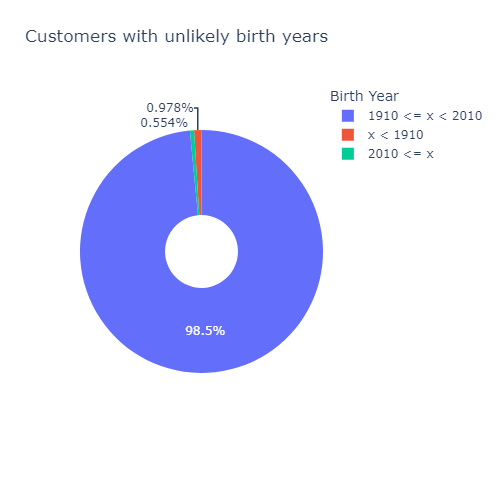

In [9]:
tmp = \
(customers_df
 .groupby('yearOfBirth')
 .agg(count=('customerId','count'))
 .groupby(lambda x: 'x < 1910' if x<1910 else '1910 <= x < 2010' if x<2010 else '2010 <= x')
 .sum()
 .reset_index())

fig = \
(px.pie(tmp, values='count', names='yearOfBirth', hole=0.3, labels={})
 .update_layout(width=500, height=500,
                title='Customers with unlikely birth years',
                legend_title_text='Birth Year'))

show_fig(fig)

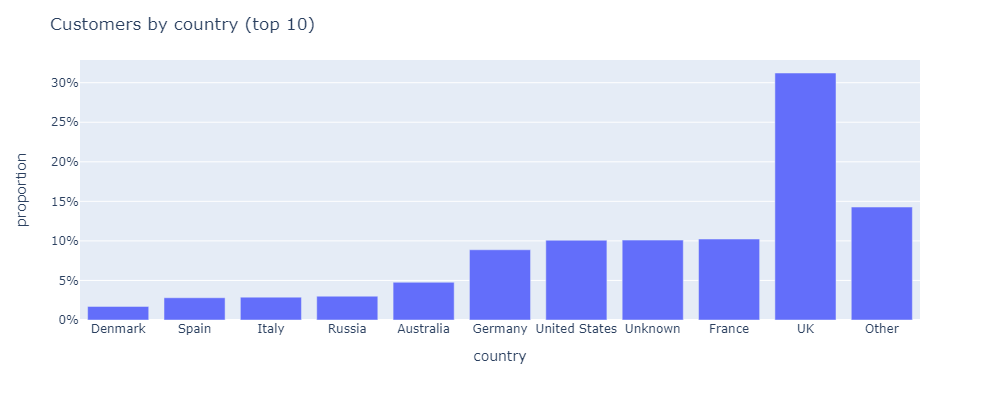

In [10]:
fig = \
(customers_df
 # get customers per country
 .groupby('country')
 .agg(count=('customerId','count'))
 .sort_values(by='count')
 # convert to proportion of all customers (in dataset)
 .assign(proportion=lambda df: df/df.sum())
 # combine all outside top 10 to 'Other'
 .T.assign(Other=lambda df: df.iloc[:,:-10].sum(axis=1)).T
 # keep only top 10 and 'Other'
 .iloc[-11:]
 # plot
 .plot.bar(y='proportion')
 .update_layout(width=1000, height=400, title='Customers by country (top 10)')
 .update_yaxes(tickformat='.0%'))

show_fig(fig)

## Purchases

- 2063803 total purchases. Sales rate increasing linearly
- 1200930 purchases with discountType=NaN - Imputed to No Discount
- spikes at Halloween sale and black friday
- Sundays consistently have more sales than saturdays
- Sales are highest on mondays, drop through the week, then jump back up on sundays

- more sales happen on promos, but are people more likely to buy an expensive item too?
- There are two big dips at 24/25 Dec and 31st/1st
- There are sales in January using the Aug 2016 discount.

We can see purchases from January, the same month we are trying to predict for. Can we sensibly use this data?

- memory reduced from 318Mb to 39Mb
- 58% of purchases have no discount
- 12% free delivery and 8% Black Friday
- 41% of purchases include a single product
- larger baskets are less frequent

To what extent can we use purchase information from Black Friday to make inferences about more normal times of the year.

In [11]:
purchase_df = load_purchase_dataset()

In [12]:
purchase_df.head().style.set_caption("""Sample of purchases dataset""") 

,customerId,productId,date,purchasePrice,discountType
0,1045,7227638,2016-12-16 21:03:29.933000,2249,No Discount
1,104614,6825797,2016-11-04 23:13:11.983000,6500,Unidays 10% Off UK/ROI - Oct 2016
2,245591,7081268,2016-12-05 19:13:30.473000,1499,No Discount
3,136967,7173611,2016-10-06 16:54:52.203000,8849,No Discount
4,264818,7328917,2016-11-06 19:14:08.313000,2849,Free Delivery


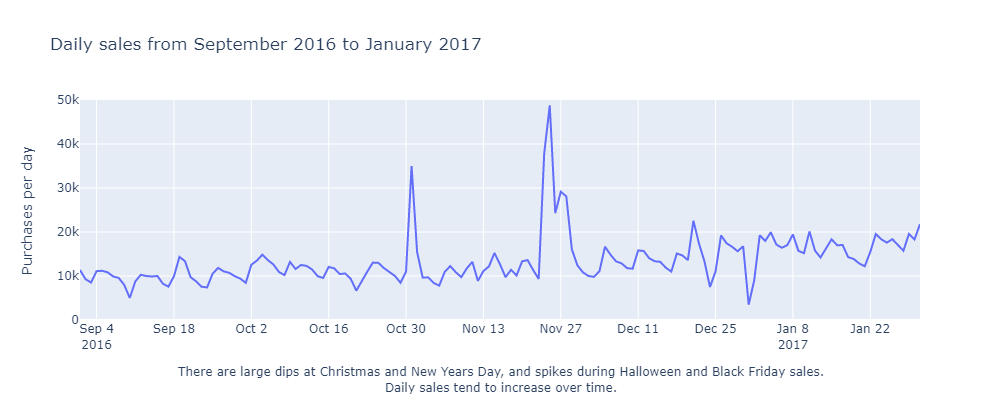

In [13]:
fig = \
(purchase_df
 .set_index('date')
 .resample('D')
 .count()
 .customerId
 .plot(title='Daily sales from September 2016 to January 2017')
 .update_xaxes(title=None)
 .update_yaxes(title='Purchases per day', range=[0,50000])
 .update_layout(width=1000, height=400, showlegend=False)
 .add_annotation(
     xref='paper',
     yref='paper',
     x=0.5, y=-0.35,
     showarrow=False,
     text='There are large dips at Christmas and New Years Day, '\
        'and spikes during Halloween and Black Friday sales.<br>'\
        'Daily sales tend to increase over time.'))

show_fig(fig)

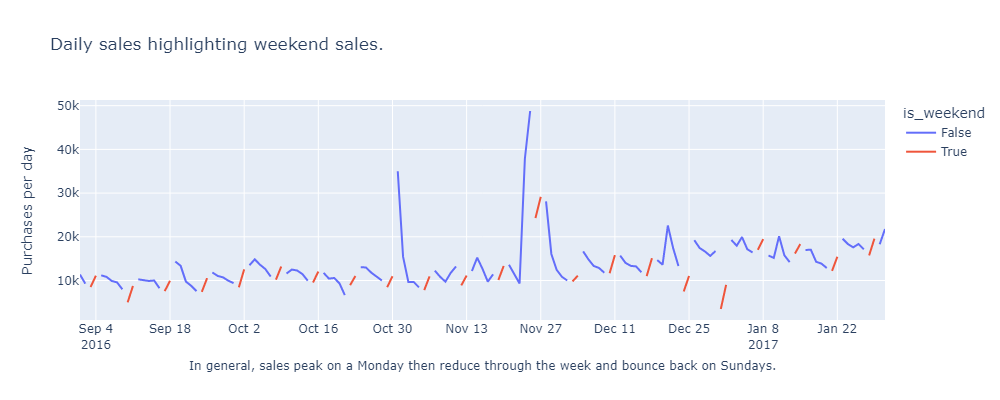

In [14]:
fig = \
(purchase_df
 # get daily sales
 .set_index('date')
 .resample('D')
 .count()
 .customerId
 # separate weekdays and weekends
 .reset_index()
 .assign(is_weekend=lambda x: x.date.dt.weekday>=5)
 .pivot(index='date', columns='is_weekend', values='customerId')
 # plot
 .plot(title='Daily sales highlighting weekend sales.')
 .update_xaxes(title=None)
 .update_yaxes(title='Purchases per day')
 .update_layout(width=1000, height=400, showlegend=True)
 .add_annotation(
     xref='paper',
     yref='paper',
     x=0.5, y=-0.25,
     showarrow=False,
     text ='In general, sales peak on a Monday then reduce through the week and bounce back on Sundays.'))

show_fig(fig)

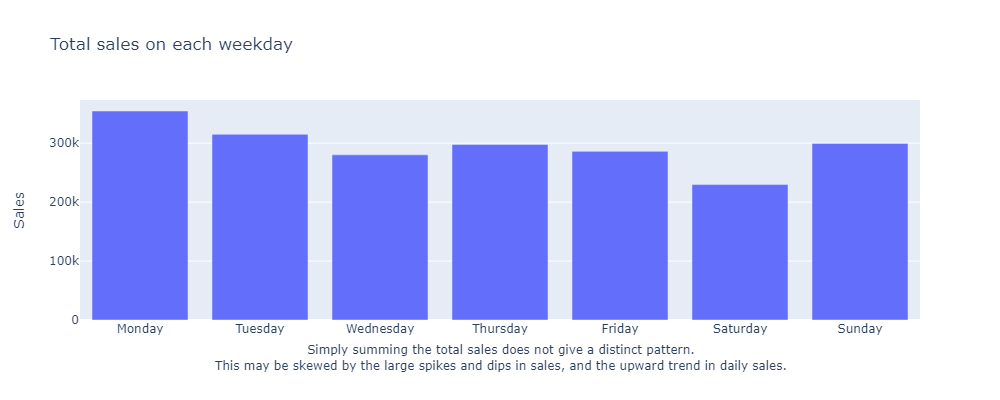

In [15]:
fig = \
(purchase_df[['customerId','date']]
 # get weekdays and day names
 .assign(weekday=lambda df: df.date.dt.weekday,
         day_name=lambda df: df.date.dt.day_name())
 # get total sales per day of week
 .groupby(['weekday','day_name'], as_index=False)
 .agg({'customerId':'count'})
 # plot
 .plot.bar(x='day_name', y='customerId', title='Total sales on each weekday')
 .update_xaxes(title=None, tickangle=0)
 .update_yaxes(title='Sales')
 .update_layout(width=1000, height=400, showlegend=False)
 .add_annotation(
     xref='paper',
     yref='paper',
     x=0.5, y=-0.25,
     showarrow=False,
     text='Simply summing the total sales does not give a distinct pattern.<br>'\
          'This may be skewed by the large spikes and dips in sales, '\
          'and the upward trend in daily sales.'))

# this plot doesn;t show the same trends as the one above
# how can i make a better plot to show how price drops through the
show_fig(fig)

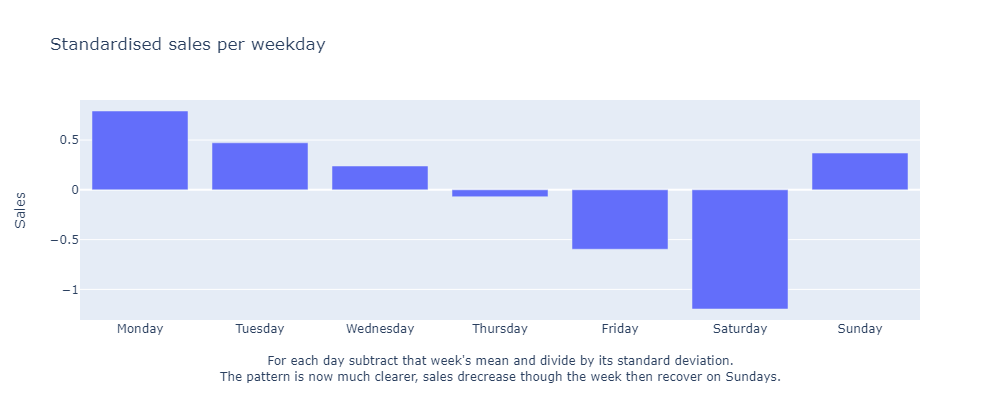

In [16]:
fig = \
(purchase_df
 # get daily sales
 .resample('D', on='date')
 .customerId
 .agg(purchaseCount='count')
 # standardise by week
 # NB. idx.week and idx.weekofyear are deprecated
 .groupby(lambda x: pd.Int64Index(x.isocalendar().week))
 .transform(lambda g: (g-g.mean())/g.std())
 # groupby day of week
 .groupby([lambda x: x.weekday, lambda x: x.day_name()])
 .mean()
 .rename_axis(['weekday','day_name'], axis=0)
 .reset_index()
 # plot
 .plot.bar(x='day_name', y='purchaseCount', title='Standardised sales per weekday')
 .update_xaxes(title=None, tickangle=0)
 .update_yaxes(title='Sales')
 .update_layout(width=1000, height=400, showlegend=False)
 .add_annotation(
     xref='paper',
     yref='paper',
     x=0.5, y=-0.30,
     showarrow=False,
     text="""For each day subtract that week's mean and divide by its standard deviation."""\
          """<br>The pattern is now much clearer, sales drecrease though the week then recover on Sundays."""))

# when we remove weekly variation
# we notice that sales go down from monday than jump back up on sunday
# Mondays are on average 0.75 st devs greater than the mean for that week.
show_fig(fig)

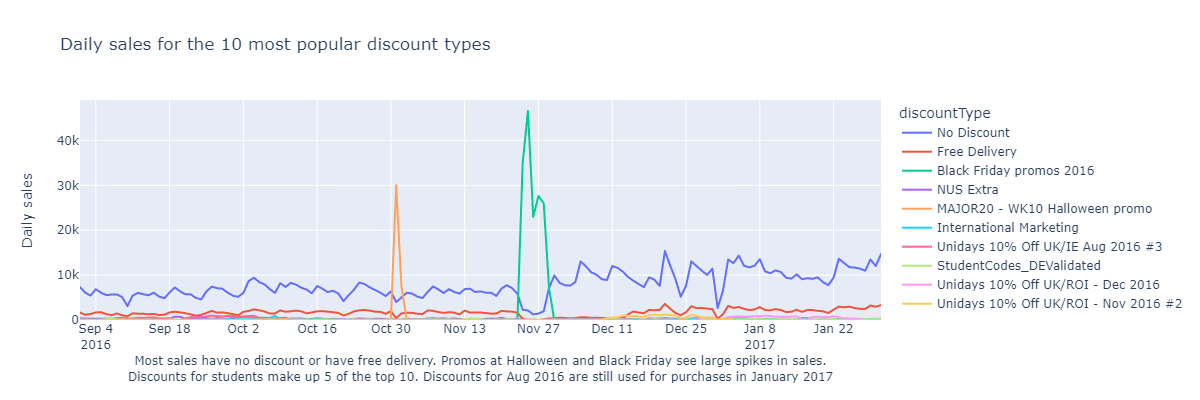

In [17]:
fig = \
(purchase_df
 # get daily sales
 .groupby([pd.Grouper(key='date', freq='D'), 'discountType'])
 .customerId
 .count()
 # index=date | columns=discountType
 .unstack()
 .fillna(0)
 # find the 10 discountTypes with the most total sales
 .iloc[:, lambda df: df.sum().argsort()[::-1][:10]]
 # plot
 .plot(title='Daily sales for the 10 most popular discount types')
 .update_xaxes(title=None, tickangle=0)
 .update_yaxes(title='Daily sales', rangemode="tozero")
 .update_layout(width=1200, height=400, showlegend=True)
 .add_annotation(
     xref='paper',
     yref='paper',
     x=0.5, y=-0.30,
     showarrow=False,
     text="""Most sales have no discount or have free delivery."""\
          """ Promos at Halloween and Black Friday see large spikes in sales."""\
          """<br>Discounts for students make up 5 of the top 10."""\
          """ Discounts for Aug 2016 are still used for purchases in January 2017"""))

show_fig(fig)

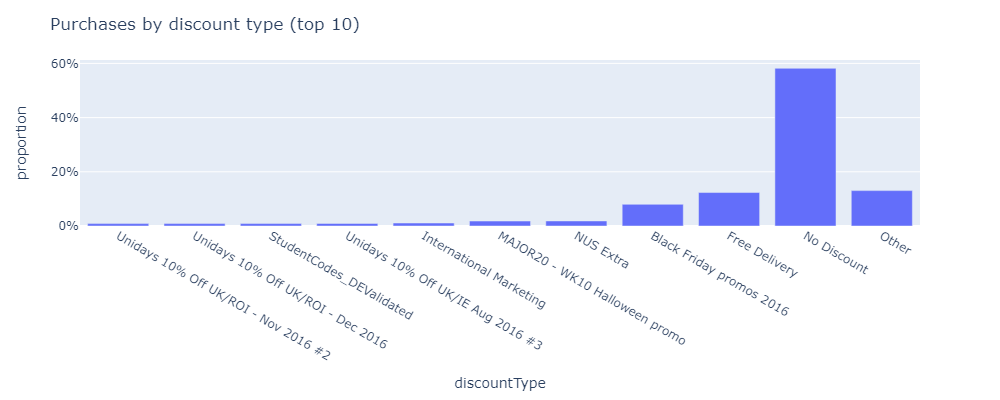

In [18]:
fig = \
(purchase_df
 # get Purchases per discount
 .groupby('discountType')
 .agg(count=('productId','count'))
 .sort_values(by='count')
 # convert to proportion of all Purchases (in dataset)
 .assign(proportion=lambda df: df/df.sum())
 # combine all outside top 10 to 'Other'
 .T.assign(Other=lambda df: df.iloc[:,:-10].sum(axis=1)).T
 # keep only top 10 and 'Other'
 .iloc[-11:]
 # plot
 .plot.bar(y='proportion')
 .update_layout(width=1000, height=400, title='Purchases by discount type (top 10)')
 .update_yaxes(tickformat='.0%'))

show_fig(fig)

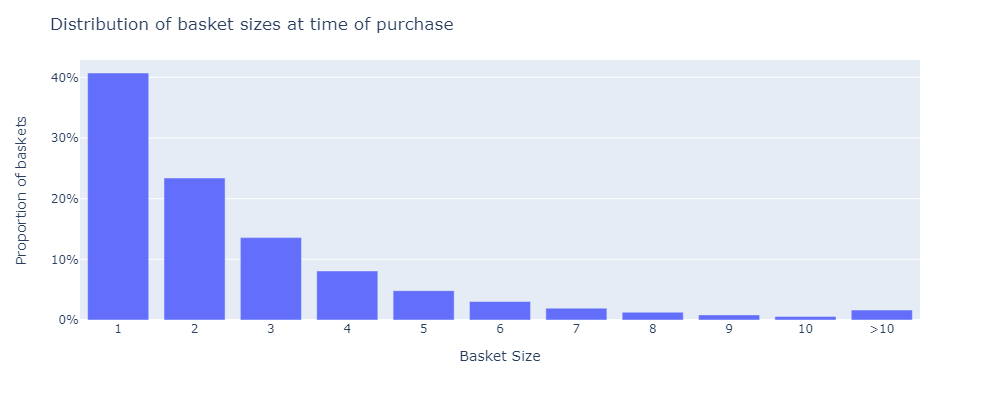

In [19]:
fig = \
(purchase_df
 # get basketSize
 .groupby(['customerId','date'])
 .agg(basketSize=('productId','count'))
 # get frequency of each basketSize
 .groupby('basketSize')
 .agg(basketSizeFreq=('basketSize','count'))
 .assign(basketSizeFreq=lambda df: df.basketSizeFreq/df.basketSizeFreq.sum())
 # combine all outside top 10 to 'Other'
 .T.assign(Other=lambda df: df.iloc[:,10:].sum(axis=1)).T
 # get first 10 rows and the last ('Other')
 .iloc[[x for x in range(10)]+[-1],:]
 # prepare for plotting
 .reset_index()
 .astype({'basketSize':str})
 .replace({'Other':'>10'})
 # plot
 .plot.bar(x='basketSize', y='basketSizeFreq')
 .update_layout(width=1000, height=400, showlegend=False,
                title='Distribution of basket sizes at time of purchase')
 .update_yaxes(title='Proportion of baskets', tickformat='.0%', rangemode="tozero")
 .update_xaxes(title='Basket Size')
 .update_traces(hovertemplate='Basket Size: %{x}<br>Proportion: %{y:.1%}',))

show_fig(fig)

## Products

Products Table:
- No missing values
- 2 products with price==0
- 142 rows have dateOnSite=='\N' all else OK, mostly from the same brand (53)
    - 3 of which have had purchases:
        - 1623346 - 2017-01-27 13:07:33.260
        - 3166732 - 2016-12-17 20:36:57.073
        - 5025234 - 2016-09-07 00:37:02.420
    - all 142 products have had views in January 2017
- productId does not go up with dateOnSite, although smaller Ids are often older.
- memory usage reduced from 20Mb to 3.4Mb

£0 products are left unchanged. Products with missing date on site are imputed to their brand mean if possible, otherwise to the mean of the entire dataset.

- there are 42 unique product types
- 1720 unique brands, 1097 have at least 10 products, and 300 at least 100 products
- between 10/12/2016-20/01/2017 products are added at a much faster rate
- 68% of products are on sale
- 25% of products are by brand 53, the next biggest brand is 2.1%
- the top 10 product types account for 61% of all products
- the most common product type (1465) makes up 16% of the dataset.
- the most expensive product is £600, the mean is £28.5
- Price has positive skew (3.55) and a Gaussian KDE is maximal at £12

In [20]:
products_df = load_product_dataset()
products_df.sample(5).style.set_caption("""Sample of products dataset""") 

,productId,brand,price,productType,onSale,dateOnSite
110875,7446134,12915,8000,943,False,2017-01-03 11:26:26
160848,7031133,13761,7800,3717,True,2016-12-19 22:44:22
20787,7312681,3738,3000,1428,False,2016-12-19 11:54:49
133494,7429320,15189,1200,1500,False,2016-12-12 09:57:47
128653,7077394,765,1700,1455,False,2016-10-19 10:19:20


### Missing Values

In [21]:
# of the products with missing dates, have any had sales?
raw_products_df = pd.read_csv(DATA_DIR/'raw'/'products.txt')

purch_df = pd.read_csv(
    DATA_DIR/'raw'/'purchases.txt',
    parse_dates=['date'],
    dtype={'customerId':np.int32, 'productId':np.int32})

(raw_products_df
 [raw_products_df.dateOnSite.str.contains(r'\\N')]
 .merge(purch_df, on='productId', how='outer')
 .dropna(subset=['brand','customerId'])
 .sort_values(['productId','date'])
 .style
 .format(precision=2)
 .format(precision=0, subset=['brand','productType','customerId','date'])
 .set_caption("""Products with missing dateOnSite which have recorded sales"""))

,productId,brand,price,productType,onSale,dateOnSite,customerId,date,purchasePrice,discountType
68,1623346,53,8.00,1600,True,\N,172114,2017-01-27 13:07:33.260000,8.00,nan
40,3166732,53,6.50,1600,True,\N,3054,2016-12-17 20:36:57.073000,6.49,Free Delivery
9,5025234,13817,8.50,943,True,\N,271451,2016-09-07 00:37:02.420000,8.50,Free Delivery
6,5025234,13817,8.50,943,True,\N,389322,2016-09-13 21:37:21.863000,8.50,nan
12,5025234,13817,8.50,943,True,\N,98373,2016-09-25 14:15:36.120000,8.50,nan
13,5025234,13817,8.50,943,True,\N,353979,2016-09-28 16:34:46.360000,8.50,nan
7,5025234,13817,8.50,943,True,\N,292640,2016-10-13 06:24:31.350000,8.50,nan
11,5025234,13817,8.50,943,True,\N,343586,2016-10-29 10:18:06.013000,8.50,nan
8,5025234,13817,8.50,943,True,\N,328185,2016-11-14 13:17:42.400000,8.61,nan
10,5025234,13817,8.50,943,True,\N,96015,2016-12-16 22:54:57.600000,8.50,NUS Extra


In [22]:
# of the products with missing dates, have any had views?
views_df = load_views_dataset()

In [23]:
missing_dates = set(raw_products_df[raw_products_df.dateOnSite.str.contains(r'\\N')].productId)
views_df[views_df.productId.isin(missing_dates)]

(views_df
 [views_df.productId.isin(missing_dates)]
 .groupby('productId')
 .agg({'date':'min'})
 .sort_values(by='date')
 .sample(10)
 .style.set_caption("""Products with missing dateOnSite which have recorded views (sample)"""))

,date
productId,
974838,2017-01-15 17:17:11
1113057,2017-01-12 06:50:28
936384,2017-01-05 14:39:29
1119944,2017-01-07 17:44:27
1295616,2017-01-01 18:29:12
1152879,2017-01-29 19:19:26
1186218,2017-01-03 03:27:23
1089549,2017-01-24 00:07:08
515086,2017-01-07 16:30:25


### Exploration

In [24]:
# how many brands have at least n products
(products_df
 .groupby('brand')
 .agg(brandProductCount=('productType','count'))
 .eval('brandProductCount_10 = brandProductCount>=10')
 .eval('brandProductCount_100 = brandProductCount>=100')
 .eval('brandProductCount_250 = brandProductCount>=250')
 .drop(columns=['brandProductCount'])
 .apply(lambda col: col.sum()/col.count())
 .to_frame('% of brands')
 .style
 .set_caption("""Brands with more than x products on site""")
 .format('{:.2%}'))

,% of brands
brandProductCount_10,63.78%
brandProductCount_100,17.44%
brandProductCount_250,7.21%


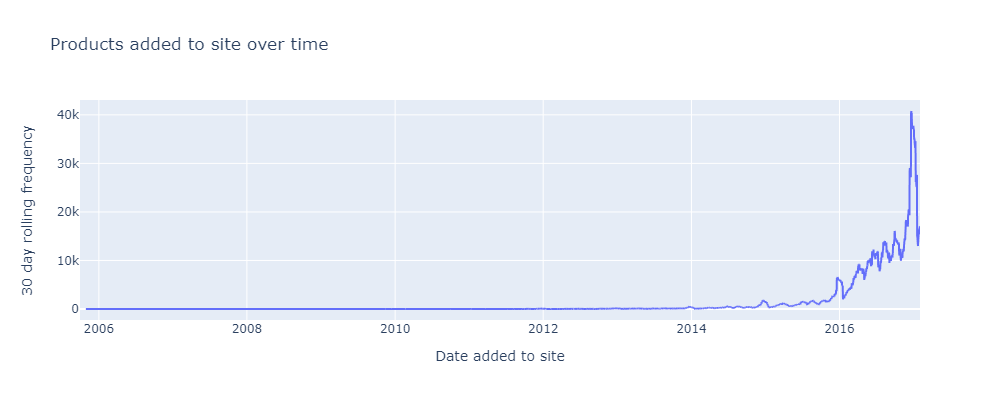

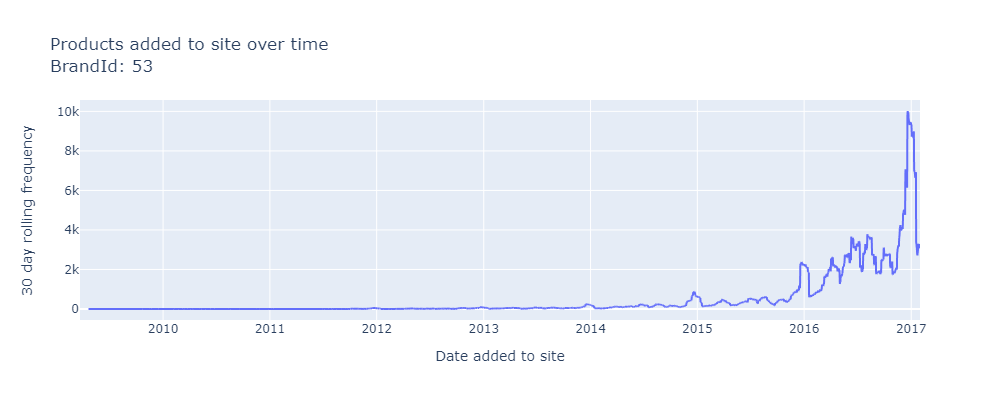

In [25]:
def plot_products_added(df, window_size=30, brandId=None):
    
    title = 'Products added to site over time'
    
    if isinstance(brandId, int):
        df = df[df.brand==brandId]
        title += f'<br>BrandId: {brandId}'

    fig = \
    (df
    .set_index('dateOnSite')
    .brand
    # get daily count
    .resample('D').count()
    # smooth to monthly count
    .rolling(window=window_size).sum()
    .plot(title=title)
    # update styling
    .update_xaxes(title='Date added to site')
    .update_yaxes(title=f'{window_size} day rolling frequency')
    .update_layout(showlegend=False, width=1000, height=400))
    
    return fig

show_fig(plot_products_added(products_df, window_size=30))
show_fig(plot_products_added(products_df, window_size=30, brandId=53))

In [26]:
(products_df[products_df.price==0]
 .style.set_caption("""Products with price==0"""))

,productId,brand,price,productType,onSale,dateOnSite
60922,7461561,407,0,1465,False,2016-12-18 11:37:59
68780,7565230,14287,0,4035,False,2017-01-13 11:35:37


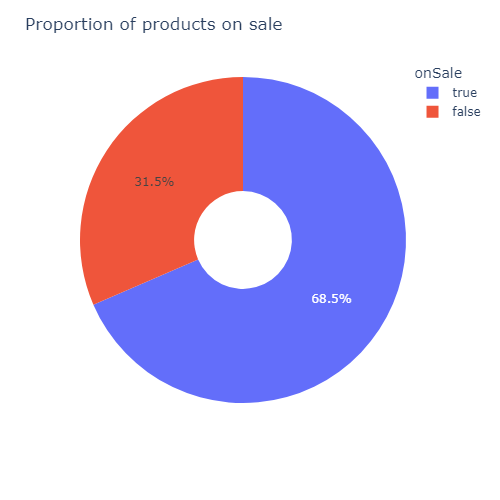

In [27]:
tmp = \
(products_df
 .groupby(['onSale'], as_index=False)
 .agg(count=('productId','count')))

fig = \
(px.pie(tmp, values='count', names='onSale', hole=0.3)
 .update_layout(width=500, height=500,
                title='Proportion of products on sale',
                legend_title_text='onSale'))

show_fig(fig)

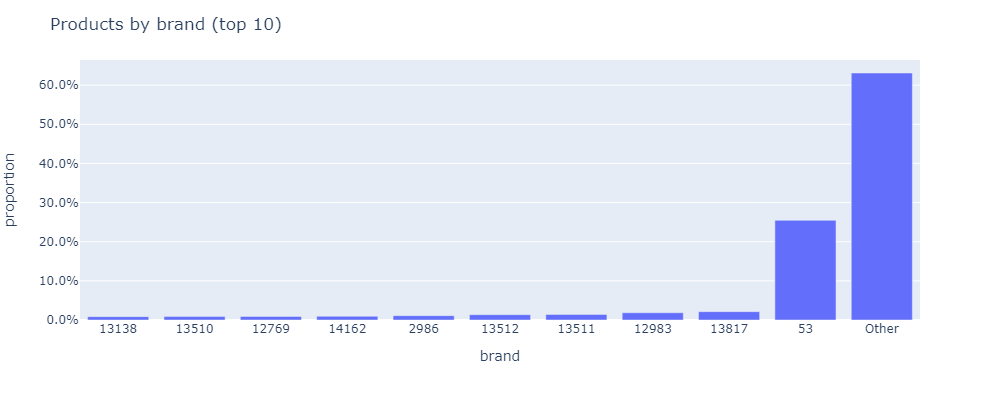

In [28]:
fig = \
(products_df
 # get customers per country
 .groupby('brand')
 .agg(count=('productId','count'))
 .sort_values(by='count')
 # convert to proportion of all customers (in dataset)
 .assign(proportion=lambda df: df/df.sum())
 # combine all outside top 10 to 'Other'
 .T.assign(Other=lambda df: df.iloc[:,:-10].sum(axis=1)).T
 # keep only top 10 and 'Other'
 .iloc[-11:]
 .reset_index()
 .astype({'brand':str})
 # plot
 .plot.bar(x='brand', y='proportion')
 .update_layout(width=1000, height=400, title='Products by brand (top 10)')
 .update_yaxes(tickformat='.1%'))

show_fig(fig)

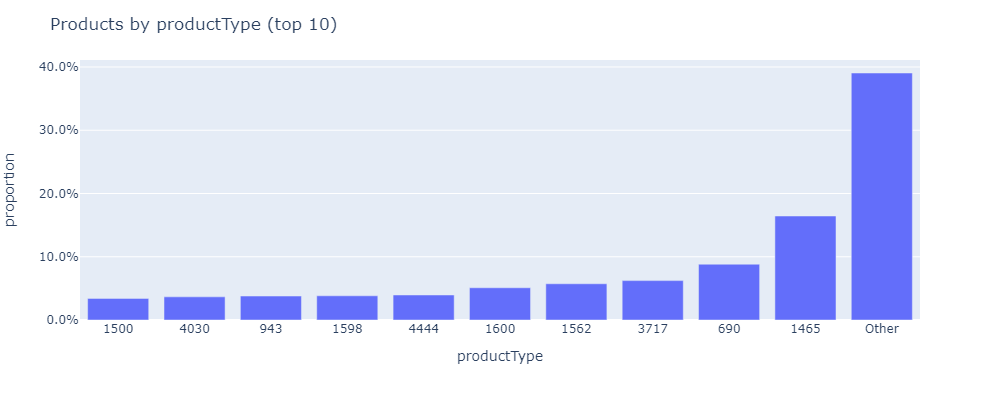

In [29]:
fig = \
(products_df
 # get customers per country
 .groupby('productType')
 .agg(count=('productId','count'))
 .sort_values(by='count')
 # convert to proportion of all customers (in dataset)
 .assign(proportion=lambda df: df/df.sum())
 # combine all outside top 10 to 'Other'
 .T.assign(Other=lambda df: df.iloc[:,:-10].sum(axis=1)).T
 # keep only top 10 and 'Other'
 .iloc[-11:]
 .reset_index()
 .astype({'productType': str})
 # plot
 .plot.bar(x='productType', y='proportion')
 .update_layout(width=1000, height=400, title='Products by productType (top 10)')
 .update_yaxes(tickformat='.1%'))

show_fig(fig)

In [30]:
((products_df.price/100)
 .describe()
 .to_frame()
 .style
 .format('{:.2f}')
 .set_caption("""Product price in whole £"""))

,price
count,192496.00
mean,28.48
std,29.97
min,0.00
25%,11.00
50%,19.50
75%,35.00
max,600.00


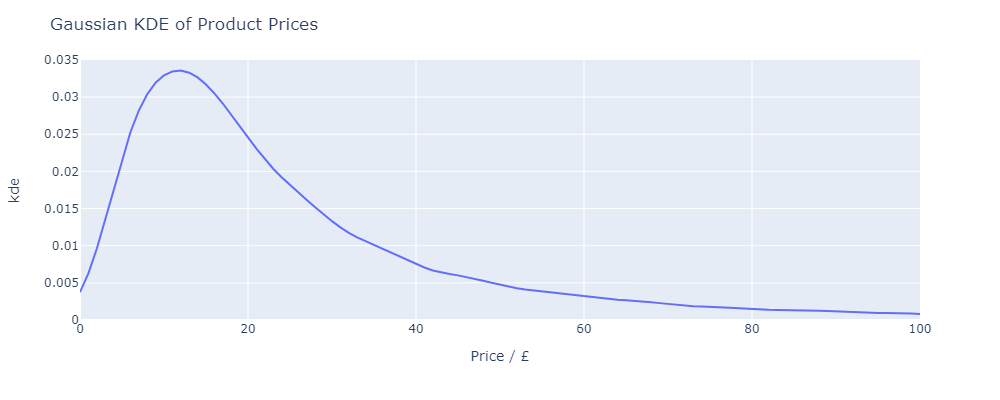

In [31]:
kernel = stats.gaussian_kde(products_df.price.values/100)

fig = \
(pd.DataFrame()
 .assign(x=list(range(100))+list(range(100,600,10)),
         kde=lambda df: kernel(df.x))
 .plot(x='x', y='kde')
 .update_layout(title='Gaussian KDE of Product Prices',
                width=1000, height=400)
 .update_xaxes(title='Price / £', range=[0,100])
 .update_yaxes(range=[0,0.035]))

show_fig(fig)

## Views

- No missing values
- reduce data size from 2640Mb to 430Mb
- 375,440 unique customers and 192,424 unique products
    - of 398,841 and 192,496 in our datasets
- there are no products in the views_df which are not in the products table
- there are 72 products in the products tables which are not viewed at all in the time period
- there are 635 customers who view items but are not in the customers table
- 24,036 customers do not view anything during this period
- most products have <100 views (~75%) but some have up to 5157
- most customers have <100 views (~85%) but some have up to 7263
- there is little variation accross the other view features

In [80]:
views_df = load_views_dataset()

In [33]:
views_df.sample(5).style.set_caption("""Sample of views dataset""") 

,customerId,productId,date,viewOnly,changeThumbnail,imageZoom,viewCatwalk,view360,sizeGuide
17475980,353873,6826698,2017-01-12 15:01:09,0,1,False,0,0,0
9500883,190731,7055873,2017-01-12 23:19:03,1,0,False,0,0,0
2929615,58910,7230486,2017-01-11 22:48:23,1,0,False,0,0,0
1506219,30469,7416113,2017-01-26 15:27:00,1,1,False,0,0,0
6632647,133025,7356019,2017-01-05 09:14:57,1,0,False,0,0,0


In [34]:
(views_df
 .drop(columns=['customerId','productId','date'])
 .describe()
 .style.set_caption("""Descriptive stats of views dataset""") )

,viewOnly,changeThumbnail,viewCatwalk,view360,sizeGuide
count,19789268.000000,19789268.000000,19789268.000000,19789268.000000,19789268.000000
mean,1.288677,0.198938,0.040380,0.001011,0.004564
std,1.761188,0.446775,0.207228,0.033100,0.086046
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,2185.000000,27.000000,18.000000,12.000000,24.000000


In [35]:
views_df[['customerId','productId']].nunique()

customerId    375440
productId     192424
dtype: int64

In [36]:
# products in views which are not in products_df
set(views_df.productId).difference(set(products_df.productId))

set()

In [37]:
# products in products_df which are not in views
products_not_viewed = set(products_df.productId).difference(set(views_df.productId))
len(products_not_viewed)

72

In [38]:
# customers in views which are not in cutomers_df
new_customers = set(views_df.customerId).difference(set(customers_df.customerId))
len(new_customers)

635

In [39]:
# a customer in the views dataset who is not in the customers table
customers_df.query('customerId==520')

,customerId,isFemale,country,yearOfBirth,isPremier


In [40]:
# customers in views which are not in cutomers_df
customers_without_views = set(customers_df.customerId).difference(set(views_df.customerId))
len(customers_without_views)

24036

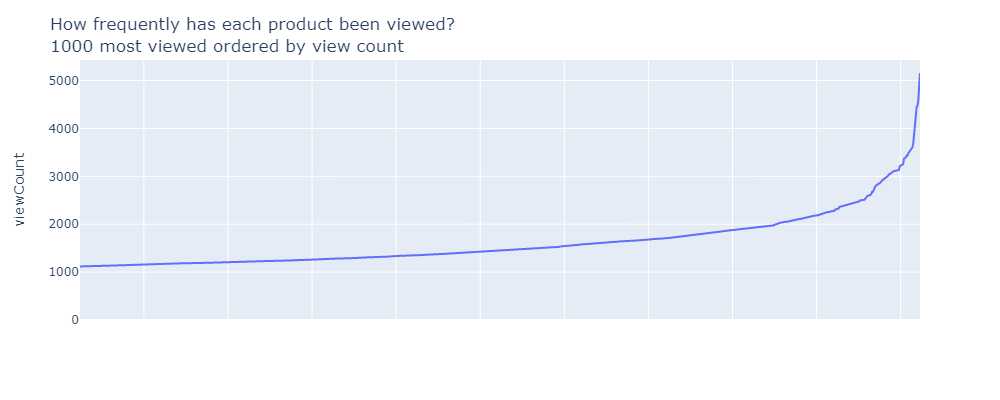

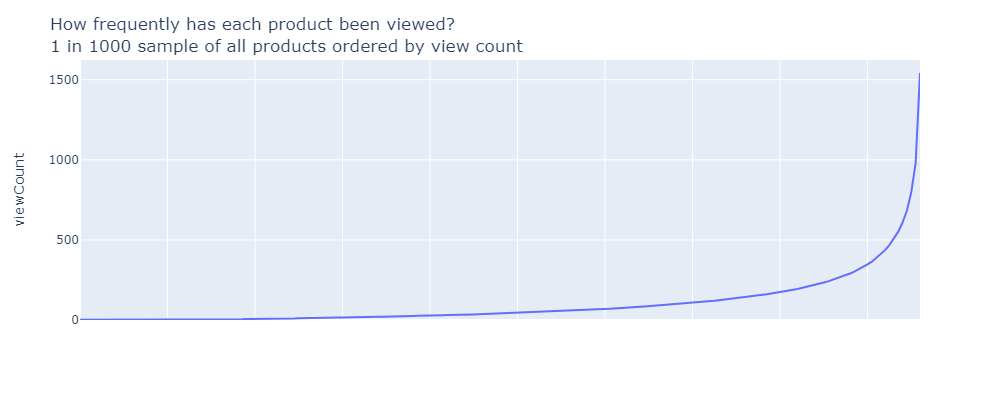

In [41]:
idx = pd.IndexSlice

for idx_slice, description in zip([idx[-1000:], idx[::1000]],
                     ['1000 most viewed', '1 in 1000 sample of all products']):
    
    fig = \
    (views_df
    .groupby('productId')
    .agg(viewCount=('customerId','count'))
    .sort_values(by='viewCount', ascending=True)
    .reset_index()
    .iloc[idx_slice]
    .plot(y='viewCount')
    .update_layout(width=1000, height=400, showlegend=False,
                   title=f'How frequently has each product been viewed?<br>{description} ordered by view count')
    .update_xaxes(title=None, showticklabels=False)
    .update_yaxes(rangemode="tozero"))
    
    show_fig(fig)

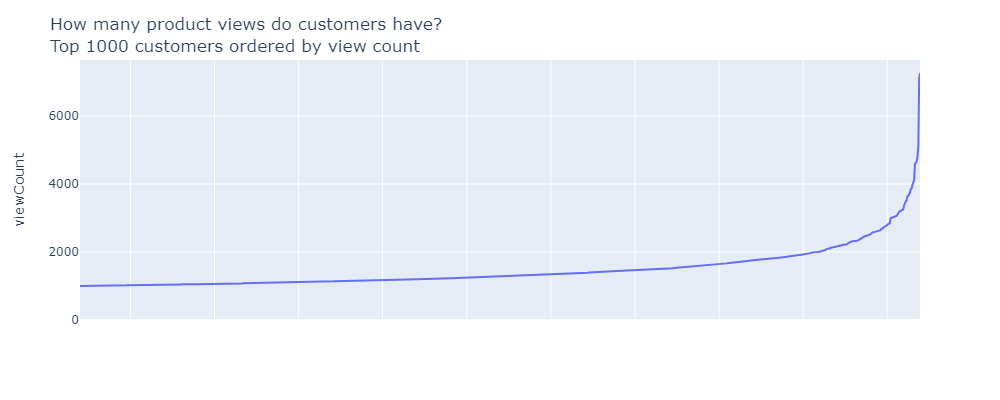

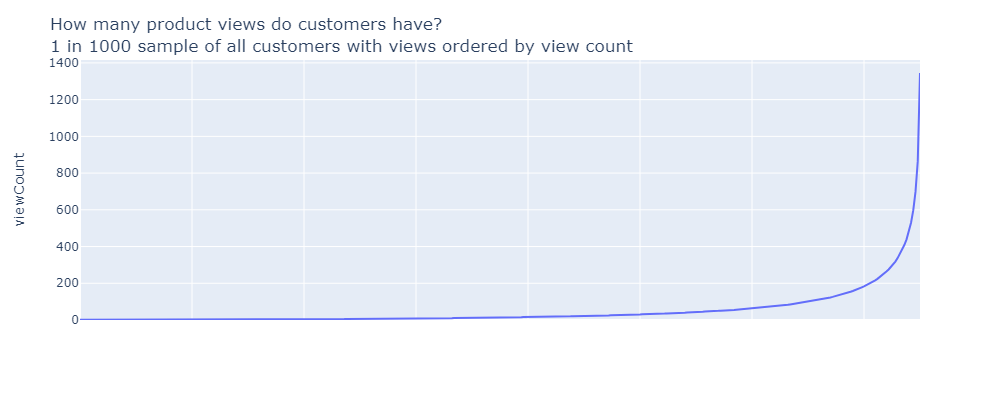

In [42]:
idx = pd.IndexSlice
idx_slices = [idx[-1000:], idx[::1000]]
descriptions = ['Top 1000 customers', '1 in 1000 sample of all customers with views']

for idx_slice, description in zip(idx_slices, descriptions):
    
    fig = \
    (views_df
    .groupby('customerId')
    .agg(viewCount=('productId','count'))
    .sort_values(by='viewCount', ascending=True)
    .reset_index()
    .iloc[idx_slice]
    .plot(y='viewCount')
    .update_layout(width=1000, height=400, showlegend=False,
                   title=f'How many product views do customers have?<br>{description} ordered by view count')
    .update_xaxes(title=None, showticklabels=False)
    .update_yaxes(rangemode="tozero"))
    
    show_fig(fig)

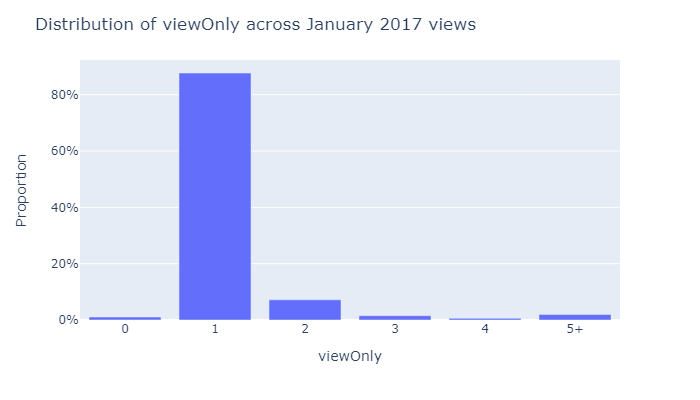

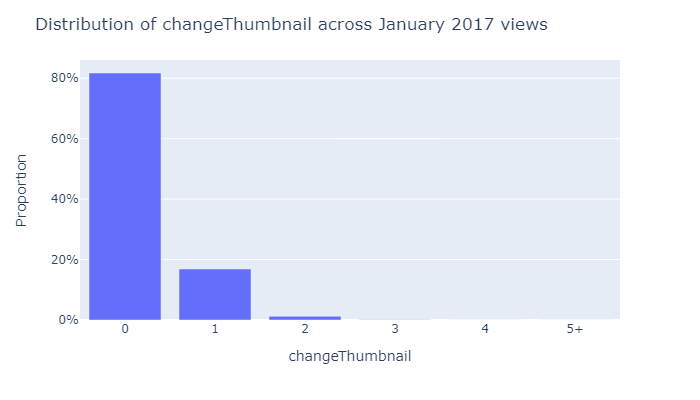

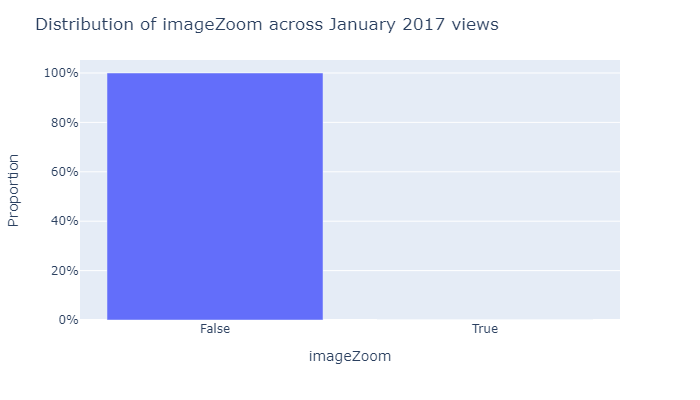

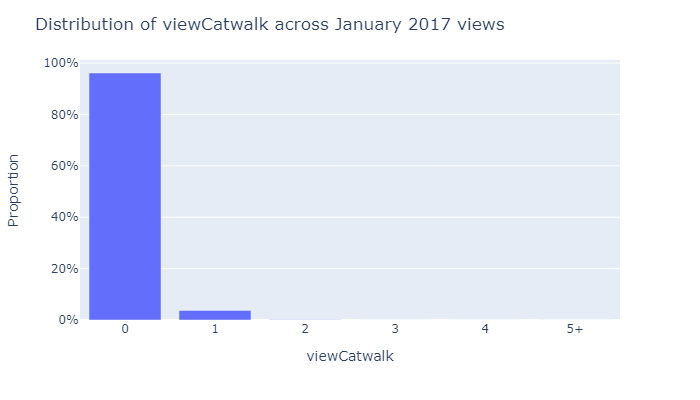

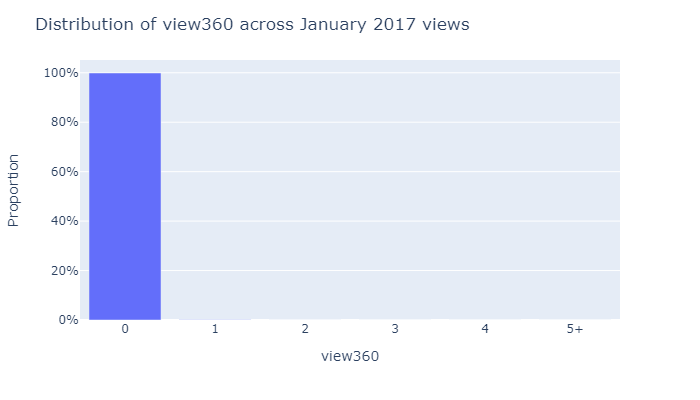

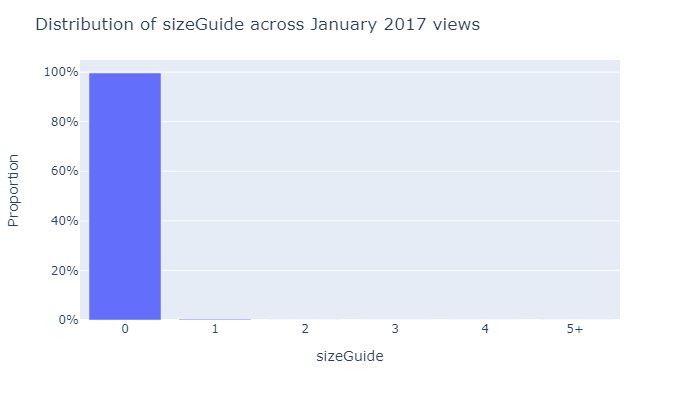

In [43]:
for feature in views_df.columns.drop(['customerId', 'productId', 'date']):
    fig = \
    (views_df
    .groupby(feature)
    .agg(featureCount=('customerId','count'))
    .apply(lambda df: df/df.sum())
    # combine all outside top 10 to 'Other'
    .T.assign(Other=lambda df: df.iloc[:,5 if feature!='imageZoom' else 2:].sum(axis=1)).T
    # get first 10 rows and the last ('Other')
    .iloc[[x for x in range(5)]+[-1] if feature!='imageZoom' else [0,1],:]
    # prepare for plotting
    .reset_index()
    .astype({feature:str})
    .replace({'Other':'5+'})
    # plotting
    .plot.bar(x=feature, y='featureCount')
    .update_layout(width=700, height=400, showlegend=False,
                    title=f'Distribution of {feature} across January 2017 views')
    .update_yaxes(title='Proportion', tickformat='.0%', rangemode="tozero")
    .update_xaxes(title=feature)
    .update_traces(hovertemplate=feature+': %{x}<br>Proportion: %{y:.1%}',))
    
    show_fig(fig)

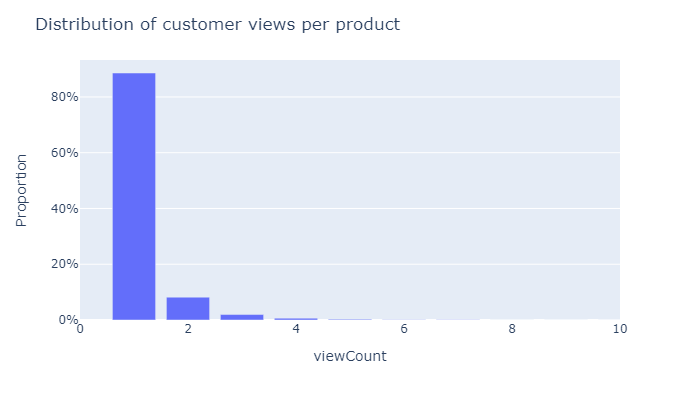

In [44]:
# distribution of views
fig = \
(views_df
 .groupby(['customerId','productId'])
 .agg(viewCount=('date','count'))
 .groupby('viewCount')
 .agg(viewCountFreq=('viewCount','count'))
 .apply(lambda df: df/df.sum())
 .plot.bar()
 .update_layout(width=700, height=400, showlegend=False, title='Distribution of customer views per product')
 .update_xaxes(range=(0,10))
 .update_yaxes(title='Proportion', tickformat='.0%', rangemode="tozero"))

show_fig(fig)

## Labels

Memory reduced from 218Mb to 115Mb. No missing data.
- 13.5 million rows in labels training
- 300,352 unique customers and 187,804 unique products
    - of 398,841 and 192,496 in our datasets
- significant class imbalance - 98% of product-customer pairs were not purchased
- all products in training are in the products table
- every product in training has been viewed this month
- 515 customers in training are not in the customers table
- every customer in training has viewed prodcts this month
- every customer-product pair in training has had at least one view
- 40,468 products in training have no recorded purchases
- 116,543 customers in training have no recorded purchases
- products which are not bought are viewed fewer times per customer.
- 65% of purchases happen after a single viewing
    - and a further 20% at second viewing

In [78]:
labels_training_df = load_labels_dataset()

In [79]:
labels_training_df.sample(10).style.set_caption("""Sample of labels training dataset""")

,customerId,productId,purchased
10531977,312973,6971805,False
4645264,136903,7347809,False
8745057,259553,5950765,False
12053506,358342,6530543,False
9981869,296591,7452342,False
13267611,393456,6381334,False
12668964,376250,7476611,False
4104237,121027,7274395,False
13437120,398316,7223291,False
2778032,81733,6895464,True


In [47]:
labels_training_df[['customerId','productId']].nunique().to_frame('n_unique')

,n_unique
customerId,300352
productId,187804


In [48]:
(labels_training_df
 .groupby(['purchased'])
 .agg(purchasedPCT=('customerId','count'))
 .transform(lambda x: 100*x/x.sum())
 .round(2)
 .style.set_caption("""Class imbalance in training dataset"""))

,purchasedPCT
purchased,
False,97.980000
True,2.020000


In [49]:
# every produyct in training exists in the products table
set(labels_training_df.productId).difference(set(products_df.productId))

set()

In [50]:
# every product in training has been viewed this month
set(labels_training_df.productId).difference(set(views_df.productId))

set()

In [51]:
# some cutomers in training do not exist in the customers table
unseen_customers = set(labels_training_df.customerId).difference(set(customers_df.customerId))
len(unseen_customers)

515

In [52]:
# every customer in training has viewed prodcts this month
set(labels_training_df.customerId).difference(set(views_df.customerId))

set()

In [53]:
# every customer-product pair in training has had at least one view
(labels_training_df
 .merge(views_df, how='left', on=['customerId','productId'])
 .isna()
 .sum())

customerId         0
productId          0
purchased          0
date               0
viewOnly           0
changeThumbnail    0
imageZoom          0
viewCatwalk        0
view360            0
sizeGuide          0
dtype: int64

In [54]:
# there are many products in training which have no recorded sales
never_purchased = set(labels_training_df.productId).difference(set(purchase_df.productId))
len(never_purchased)

40468

In [55]:
# there are many products in training which have no recorded sales
no_purchase_history = set(labels_training_df.customerId).difference(set(purchase_df.customerId))
len(no_purchase_history)

116543

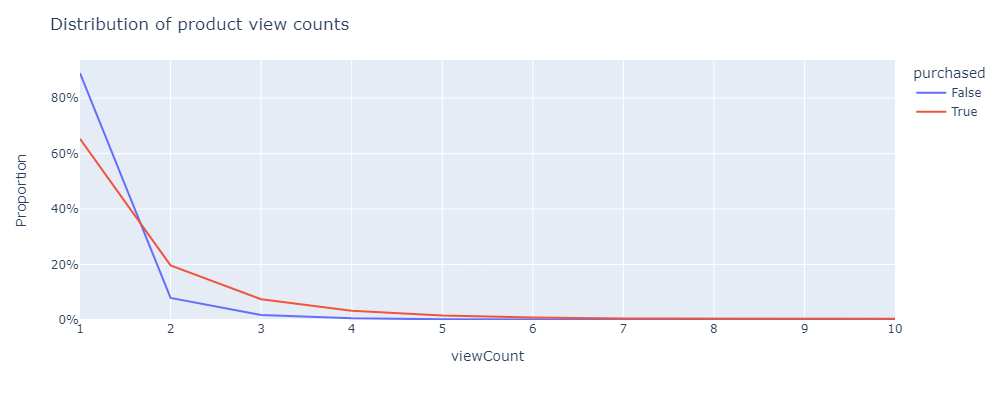

In [56]:
# distribution of views
fig = \
(# join views with training data
 views_df
 .merge(labels_training_df, how='left', on=['customerId','productId'])
 [['customerId','productId','purchased','viewOnly']]
 .dropna(subset=['purchased'])
 # get times each customer viewed each product - split by if they bought
 .groupby(['purchased','customerId','productId'])
 .agg(viewCount=('viewOnly','count'))
 .reset_index()
 # get frequency of view counts - split by if they bought
 .groupby(['purchased','viewCount'])
 .agg(viewCountFreq=('customerId','count'))
 # convert frequency to density
 .groupby(level='purchased')
 .transform(lambda g: g/g.sum())
 # reshape dataframe for plotting
 .unstack('purchased')
 .fillna(0)
 .droplevel(0, axis=1)
 # plotting
 .plot()
 .update_layout(width=1000, height=400, title='Distribution of product view counts')
 .update_xaxes(range=[1,10])
 .update_yaxes(title='Proportion', rangemode='tozero', tickformat='.0%')
 .update_traces(hovertemplate='viewCount: %{x}<br>Proportion: %{y:.2%}'))

show_fig(fig)

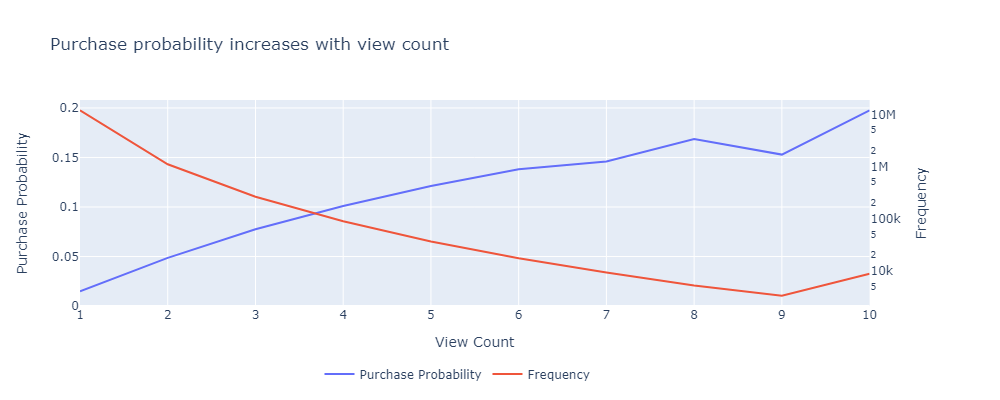

In [502]:
# distribution of views
tmp = \
(# join views with training data
 views_df
 .merge(labels_training_df, how='left', on=['customerId','productId'])
 [['customerId','productId','purchased','viewOnly']]
 # some views are related to the test set
 .dropna(subset=['purchased'])
 # get times each customer viewed each product and if bought
 .groupby(['customerId','productId'])
 .agg(viewCount=('viewOnly','count'), purchased=('purchased','first'))
 # bin larger view counts
 .assign(viewCountBinned=lambda df: df.viewCount.where(df.viewCount<10, 10, axis=0))
 # get purchase prob and number in bin
 .groupby('viewCountBinned', as_index=False)
 .agg(purchaseProbability=('purchased','mean'), purchaseCount=('purchased','count')))

fig = \
(make_subplots(specs=[[{"secondary_y": True}]])
 .add_traces(
     px.line(tmp, x='viewCountBinned', y='purchaseProbability').data + \
     px.line(tmp, x='viewCountBinned', y='purchaseCount').data, secondary_ys=[False,True])
 # set trace names and add to legend
 .update_traces(name='Purchase Probability', secondary_y=False, showlegend=True)
 .update_traces(name='Frequency', secondary_y=True, showlegend=True)
 # figure formatting and legend
 .update_layout(
     width=1000, height=400,
     title='Purchase probability increases with view count',
     legend=go.layout.Legend(
         orientation='h',
         yanchor="bottom",y=-.4,
         xanchor="center",x=0.45))
 # axes formatting
 .update_xaxes(title="View Count", ticktext=[x for x in range(1,10)]+['≥10'])
 .update_yaxes(title="Purchase Probability", secondary_y=False, rangemode='tozero')
 .update_yaxes(title="Frequency", type="log", showgrid=False, secondary_y=True)
 # line color matches trace
 .for_each_trace(lambda t: t.update(line_color=t.marker.color)))

show_fig(fig)

## Combined

- There are customerIds in the labels_training file which are not in the customers.txt
    - 14846 rows in labels_training.txt
- 40282 customers do not have a set country.
- 98% of customerId-productId pairs are NOT purchases

In [57]:
purchase_df = load_purchase_dataset()
customers_df = load_customer_dataset()
products_df = load_product_dataset()
views_df = load_views_dataset()
labels_training_df = load_labels_dataset()

In [58]:
df = \
(labels_training_df
 .merge(customers_df, on='customerId', how='left')
 .merge(products_df, on='productId', how='left')
 .merge(purchase_df, on=['customerId', 'productId'], how='left'))

In [59]:
len(labels_training_df), len(customers_df),len(products_df), len(views_df), len(df), len(purchase_df)

(13481429, 398841, 192496, 19789268, 13495792, 2063803)

There is a 19 year old spanish girl who looked at the same product 204 times in january, and viewed one other product once.

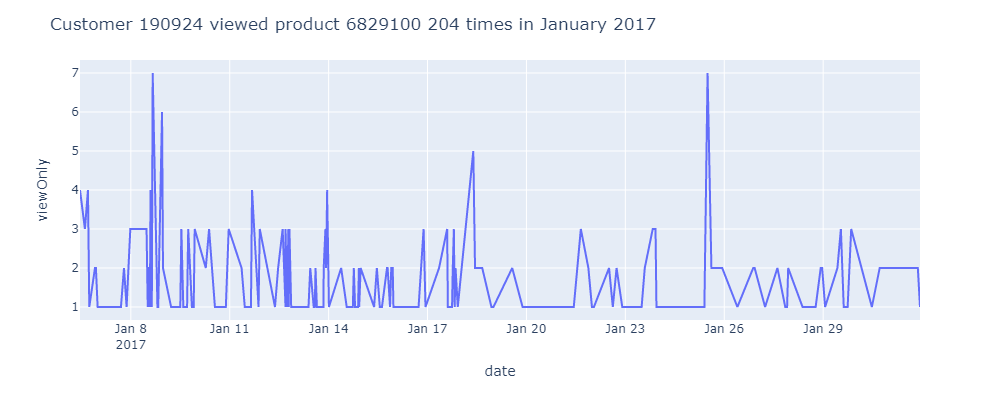

In [60]:
fig = \
(views_df
 [(views_df.customerId==190924)&(views_df.productId==6829100)]
 .sort_values(by='date')
 .plot(x='date',y='viewOnly')
 .update_layout(width=1000, height=400,
                title='Customer 190924 viewed product 6829100 204 times in January 2017'))

show_fig(fig)

Here is someone who viewed the product on the 4th, then again on the 24th, and bought it 10 minutes later. Only one person in the dataset has bought this product.

In [61]:
(views_df
 [(views_df.customerId==1)&(views_df.productId==6776789)]
 .sort_values(by='date')
 .style.set_caption("""Customer viewed this product on the 4th, then again on the 24th ..."""))

,customerId,productId,date,viewOnly,changeThumbnail,imageZoom,viewCatwalk,view360,sizeGuide
22,1,6776789,2017-01-04 00:14:08,1,1,False,0,0,0
21,1,6776789,2017-01-24 13:39:34,1,1,False,0,0,0


In [62]:
df[(df.customerId==1)&(df.productId==6776789)].style.set_caption("""... and bought the product 10 minutes later""")

,customerId,productId,purchased,isFemale,country,yearOfBirth,isPremier,brand,price,productType,onSale,dateOnSite,date,purchasePrice,discountType
19,1,6776789,True,True,UK,1983.000000,False,14644,1000,1600,True,2016-12-19 22:45:50,2017-01-24 13:50:57.753000,1000.000000,No Discount


In [63]:
df[(df.purchased==True)&(df.productId==6776789)].style.set_caption("""The only sale of this product in January""")

,customerId,productId,purchased,isFemale,country,yearOfBirth,isPremier,brand,price,productType,onSale,dateOnSite,date,purchasePrice,discountType
19,1,6776789,True,True,UK,1983.000000,False,14644,1000,1600,True,2016-12-19 22:45:50,2017-01-24 13:50:57.753000,1000.000000,No Discount


## Labels Predict

How can we justify examining the test dataset? The experimentalist has gathered the training and testing data and knows where they come from. I should know whether labels_testing is eg: a random subset, then next month, split on product etc. I can't imagine a scenario where that would be hidden. 

Based on this, splitting on customerId is clearly the sensible option. My argument against this splitting is negated as we now know that all customers in test are unseen.

Following this logic I could argue for more in depth exploration to reverse engineer the train-test splitting process. For example I may learn that the datasets were generated using stratified splitting, containing equal proportions of certain customer features. However I feel this could step too far. I do not want to influence choices such as feature elimination based on information I should not have access to. Eg. if I find out that the test set is almost entirely from one country that may affect how I treat that feature in the modelling.

- There are no overlapping customers between labels_training and labels_predict.
- Some products in labels_predict do not appear in labels_training, but the vast majority do
- 80:20 train:test split 

As mentioned in the task description, purchases.txt includes all purchases in January, including those we are trying to predict. We need to be very careful how we use this dataset to avoid leakage.

In [64]:
labels_test_df = pd.read_csv(DATA_DIR/'raw'/'labels_predict.txt')

In [65]:
labels_test_df[['customerId','productId']].nunique().to_frame('n_unique')

,n_unique
customerId,75088
productId,162994


In [66]:
# there are no overlapping customers
set(labels_training_df.customerId) & set(labels_test_df.customerId)

set()

In [67]:
# train test split ratio is 80:20
a, b = labels_training_df.customerId.nunique(), labels_test_df.customerId.nunique()
a/(a+b)

0.8

In [68]:
# most products in validation exist in training, but not all
len(set(labels_training_df.productId) & set(labels_test_df.productId))

158374

In [69]:
# verify that purchases_df includes purchases probabilities we are trying to predict
(labels_test_df
 .merge(purchase_df.query("""date > '2016-12-31 23:59:59'"""), how='inner', on=['customerId','productId'])
 .sample(10)
 .style.set_caption("""The purchase dataset includes sales present in the testing set"""))

,customerId,productId,purchase_probability,date,purchasePrice,discountType
3524,20858,7645130,nan,2017-01-30 18:43:38.710000,1500,No Discount
60480,352340,7369429,nan,2017-01-30 10:25:44.237000,2498,CYBER10 - 10% off RU/TW
66029,386710,6953135,nan,2017-01-20 07:24:16.847000,2000,No Discount
65014,380331,6683647,nan,2017-01-02 21:56:19.800000,2200,No Discount
33111,189842,6467767,nan,2017-01-14 13:55:25.190000,2000,No Discount
40600,233964,7451513,nan,2017-01-22 13:12:28.663000,2458,International Marketing
21837,124200,6495186,nan,2017-01-17 19:56:20.220000,1050,No Discount
67597,395447,6472825,nan,2017-01-22 14:11:32.553000,2000,A-LIST_NDD_3uses
51607,299857,7201114,nan,2017-01-11 16:54:01.867000,1011,No Discount
41581,239657,7157493,nan,2017-01-17 22:33:15.630000,1200,No Discount


# Computed Features

In [457]:
tmp = pd.read_feather(DATA_DIR/'processed'/'full'/'train_full.feather')
correlation_df = tmp.corr()

In [458]:
correlation_df[['purchased']].iloc[1:].style.background_gradient(cmap='RdBu_r',axis=0, vmin=-0.1,vmax=0.1)  

,purchased
isFemale,-0.028609
yearOfBirth,-0.011210
price,-0.044345
onSale,0.002362
daysOnSite,-0.001555
productId_viewCount,0.110128
productType_viewCount,-0.029344
brand_viewCount,-0.007572
productId_logOverallCustomerPurchaseRate,0.042085
productType_logOverallCustomerPurchaseRate,-0.024577


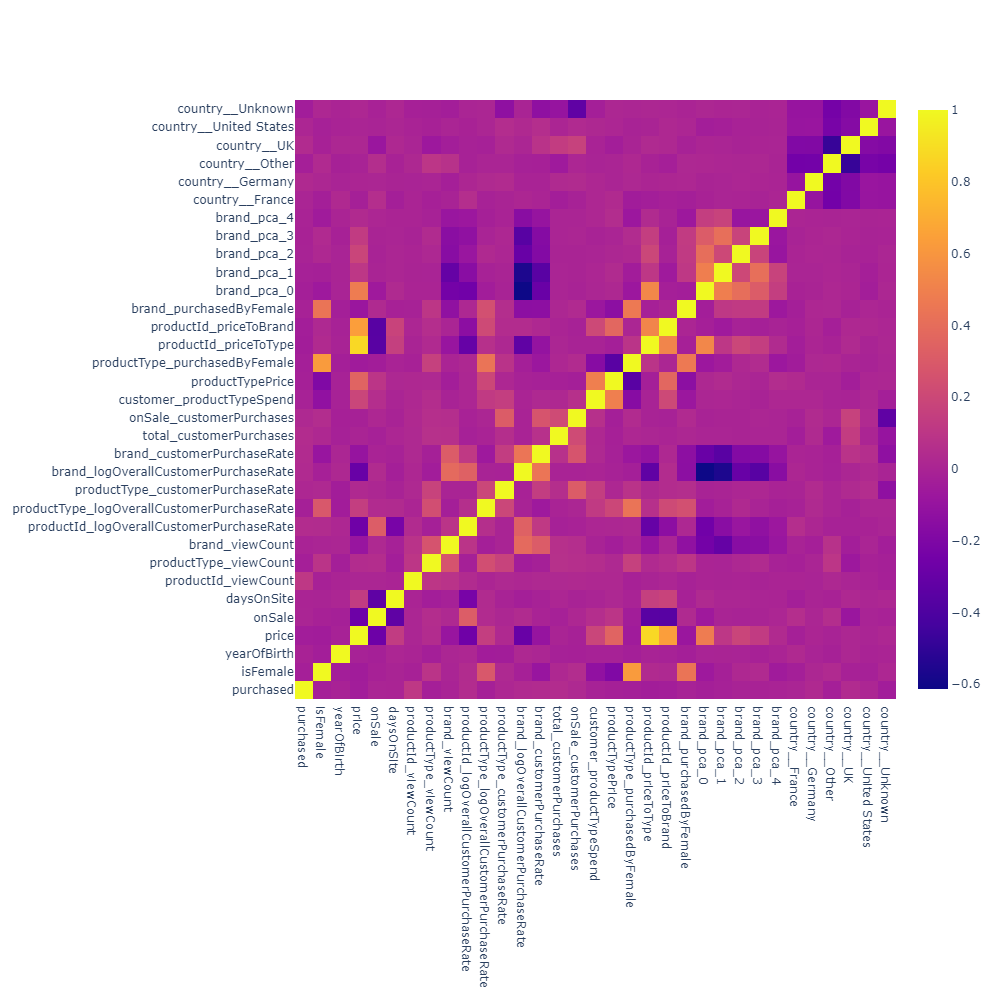

In [459]:
fig = \
(go.Figure(
    data=go.Heatmap(
        z=correlation_df.values,
        x=correlation_df.columns,
        y=correlation_df.columns))
 .update_layout(width=1000,height=1000))

show_fig(fig)

In [460]:
test = correlation_df.copy()
test.values[np.triu_indices(len(test), 1)] = None
(test
 .style.background_gradient(cmap='RdBu_r',axis=0, vmin=-0.1,vmax=0.1)
 .set_table_styles([{
    'selector': 'th.row_heading',
    'props': 'color: darkgrey; font-weight:bold; background-color:#000066;'}])
 .set_sticky(axis=0))

,purchased,isFemale,yearOfBirth,price,onSale,daysOnSite,productId_viewCount,productType_viewCount,brand_viewCount,productId_logOverallCustomerPurchaseRate,productType_logOverallCustomerPurchaseRate,productType_customerPurchaseRate,brand_logOverallCustomerPurchaseRate,brand_customerPurchaseRate,total_customerPurchases,onSale_customerPurchases,customer_productTypeSpend,productTypePrice,productType_purchasedByFemale,productId_priceToType,productId_priceToBrand,brand_purchasedByFemale,brand_pca_0,brand_pca_1,brand_pca_2,brand_pca_3,brand_pca_4,country__France,country__Germany,country__Other,country__UK,country__United States,country__Unknown
purchased,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
isFemale,-0.028609,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
yearOfBirth,-0.011210,-0.035429,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
price,-0.044345,-0.048432,-0.016090,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
onSale,0.002362,-0.017850,-0.024617,-0.276342,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
daysOnSite,-0.001555,-0.004041,0.009859,0.133006,-0.333418,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
productId_viewCount,0.110128,-0.018308,-0.000708,0.006341,0.006799,-0.000902,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
productType_viewCount,-0.029344,0.087978,-0.030829,0.043576,0.048126,-0.035430,0.100218,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
brand_viewCount,-0.007572,0.001549,0.006975,-0.093452,0.022538,-0.021835,0.079966,0.261146,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
productId_logOverallCustomerPurchaseRate,0.042085,0.040584,0.015301,-0.266686,0.313714,-0.229832,0.037690,-0.026498,0.088519,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
